In [2]:
import numpy as np
import numpy.linalg as LA

from udacidrone.frame_utils import global_to_local
from planner import Planner, Plan
from planning_utils import read_global_home

%matplotlib inline

9 waypoints



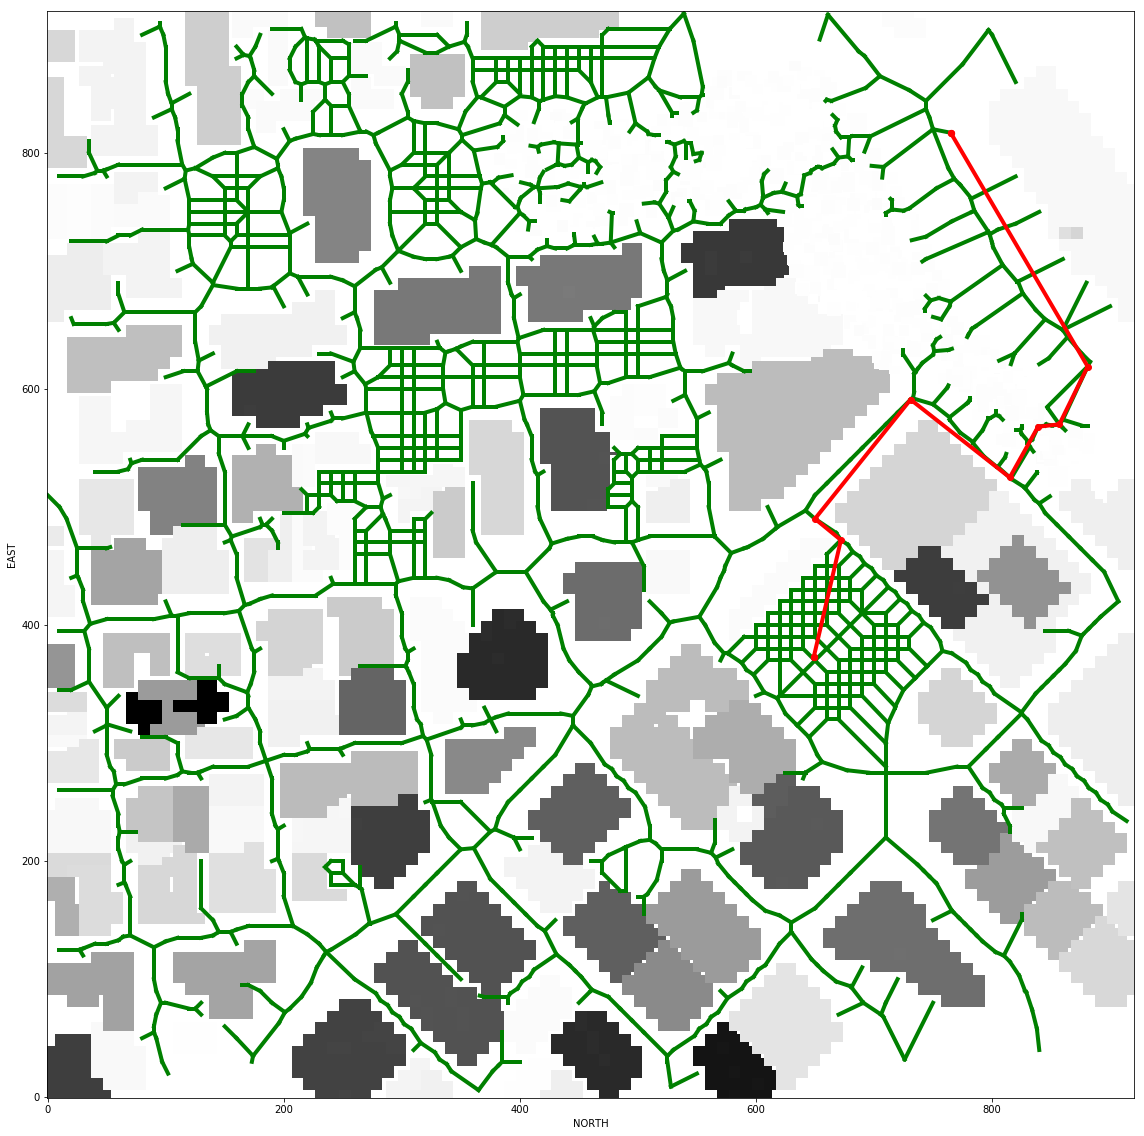

In [14]:
# Setup home, start, goal
cands = {
    "home": [-122.397450, 37.792480, 0],
    "market st": [-122.395788, 37.793772, 0.],
    "drum st": [-122.396385, 37.795124, 0.],
    "front st": [-122.398925, 37.792702, 0.],
    "clay-davis cross": [-122.398249, 37.796079, 0.],
    "clay-davis forest": [-122.398087, 37.796235, 0.],
    "washington st forest": [-122.396553, 37.797314, 0.],
    "flat mall": [-122.395127, 37.792985, 0.],
    "fremont st": [-122.397800, 37.790606, 0.],
    "fremont alley": [-122.398470, 37.790556, 0.],
    "bush-market cross": [-122.399595, 37.790689, 0.],
    "sutter-market cross": [-122.400839, 37.789681, 0.],
    "front-california cross": [-122.399220, 37.793537, 0.],
    "sacramento st": [-122.399008, 37.794815, 0.],
    "washington-battery cross": [-122.401233, 37.796779, 0.],
    "the embarcadero": [-122.393771, 37.796983, 0.],
}

global_home = read_global_home("colliders.csv")

#start_global = cands["home"]
#goal_global = cands["washington-battery cross"]
names = list(cands.keys())
def get_endpoints(verbose=True):
    start_name, goal_name = [ names[idx] for idx in np.random.choice(a=np.arange(len(names)), size=2, replace=False) ]
    if verbose:
        print("start: ", start_name)
        print("goal: ", goal_name)
    start_global = cands[start_name]
    goal_global = cands[goal_name]
    start = global_to_local(start_global, global_home)
    goal = global_to_local(goal_global, global_home)
    return start, goal

start = global_to_local(cands["the embarcadero"], global_home)
goal = global_to_local(cands["flat mall"], global_home)

#start,goal = get_endpoints()

# Setup Planner
planner = Planner("colliders.csv",
                  raw=Plan.VORONOI,
                  local=Plan.SIMPLE,
                  drone_alt=5,
                  safe_dist=3,
                  prune_raw=True,
                  greedy_prune=True,
                  verbose=False)
planner.plan_path(start, goal)

raw_path = planner.raw_waypoints

path = []
while True:
    points = planner.get_waypoints()
    if points == []:
        break
    path.extend(points)

print("{} waypoints\n".format(len(path)))


# visualize 2d graph
planner.viz_path(
    path,
    graph=None,
    draw_graph=True,
    draw_line=True,
    draw_points=True,
    draw_end_points=True,
    grid_binary=False,
    grid_alt_offset=True)

In [4]:
# Examine some graph details
G = planner.aux_2d_graph
grid = planner.grid

L = grid.shape[0]
n_diag = (sum(list(range(L-2)))*2 + L-1) * 2
n_nodes = L*L
n_edges = (L-1)*L + (L-1)*L + n_diag
grid_b = n_edges / float(n_nodes)
grid_d = 1

print("2.5D grid, shape ", grid.shape)
print("N_nodes: ", n_nodes)
print("N_edges: ", n_edges)
print("branching factor: {:.2f}".format(grid_b))
print("E[depth]: {:.2f}".format(grid_d))

n_graph_nodes = len(G.nodes)
n_graph_edges = len(G.edges)
graph_b = n_graph_edges / float(n_graph_nodes)
graph_d = 1

print("\nVoronoi graph:")
print("N_nodes: ", n_graph_nodes)
print("N_edges: ", n_graph_edges)
print("branching factor: {:.2f}".format(graph_b))
print("E[depth]: {:.2f}".format(graph_d))

2.5D grid, shape  (921, 921)
N_nodes:  848241
N_edges:  3383764
branching factor: 3.99
E[depth]: 1.00

Voronoi graph:
N_nodes:  1697
N_edges:  2010
branching factor: 1.18
E[depth]: 1.00


In [11]:
# Test traveling around 20 random locations int the city
import time

#raw_plan = Plan.GRID
raw_plan = Plan.VORONOI

p1 = \
  Planner(
    "colliders.csv",
    raw=raw_plan,
    local=Plan.SIMPLE,
    drone_alt=5,
    safe_dist=3,
    prune_raw=False,
    greedy_prune=False,
    verbose=False)

p2 = \
  Planner(
    "colliders.csv",
    raw=raw_plan,
    local=Plan.SIMPLE,
    drone_alt=5,
    safe_dist=3,
    prune_raw=True,
    greedy_prune=False,
    verbose=False)

p3 = \
  Planner(
    "colliders.csv",
    raw=raw_plan,
    local=Plan.SIMPLE,
    drone_alt=5,
    safe_dist=3,
    prune_raw=True,
    greedy_prune=True,
    verbose=False)

p_list = [p1, p2, p3]


def plan_path(planner, start, goal):
    tic = time.time()
    planner.plan_path(start, goal)
    toc = time.time()
    time_cost = toc-tic
    
    # calculate path
    path = []
    while True:
        points = planner.get_waypoints()
        if points == []:
            break
        path.extend(points)
    n_points = len(path)

    # calculate distance
    dist = 0.
    for i in range(n_points):
        if i != 0:
            offset = np.array(path[i-1])-np.array(path[i])
            dist += LA.norm(offset)
    
    return n_points, dist, time_cost


N_LOCATIONS = 20
N_PLANNER = 3

n_waypoints = [0, 0, 0]
dist_list = [0., 0., 0.]
time_cost = [0., 0., 0.]
for i in range(N_LOCATIONS):
    print("stop{}".format(i))
    start, goal = get_endpoints(verbose=True)
    for j in range(N_PLANNER):
        n_points,dist,t_cost = plan_path(p_list[j], start, goal)
        time_cost[j] += t_cost
        n_waypoints[j] += n_points
        dist_list[j] += dist

format_str = "{0:.1f} waypoints / {1:.2f} m / {2:.2f} s"
for i in range(N_PLANNER):
    avg_num = n_waypoints[i] / float(N_LOCATIONS)
    avg_dist = dist_list[i] / float(N_LOCATIONS)
    avg_time = time_cost[i] / float(N_LOCATIONS)
    print(format_str.format(avg_num, avg_dist, avg_time))

stop0
start:  clay-davis cross
goal:  sacramento st
stop1
start:  clay-davis cross
goal:  sutter-market cross
stop2
start:  fremont st
goal:  market st
stop3
start:  bush-market cross
goal:  fremont st
stop4
start:  fremont st
goal:  the embarcadero
stop5
start:  clay-davis forest
goal:  drum st
stop6
start:  front st
goal:  bush-market cross
stop7
start:  home
goal:  market st
stop8
start:  sacramento st
goal:  bush-market cross
stop9
start:  home
goal:  market st
stop10
start:  clay-davis cross
goal:  fremont alley
stop11
start:  drum st
goal:  sacramento st
stop12
start:  bush-market cross
goal:  fremont st
stop13
start:  market st
goal:  sacramento st
stop14
start:  clay-davis forest
goal:  bush-market cross
stop15
start:  flat mall
goal:  clay-davis cross
stop16
start:  the embarcadero
goal:  flat mall


IndexError: index 921 is out of bounds for axis 1 with size 921